# FSGM(Fast Gradient Sign Method) を再現する

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms.v2 as T
import numpy as np
import matplotlib.pyplot as plt
from models import setup_model


In [2]:
# runtime parameters
MODEL_PATH = './model_relu3.pt'
epsilons = [0., .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .15, .2, .25, .3]
torch.manual_seed(114514)

In [3]:
checkpoint = torch.load(MODEL_PATH, mmap=True)
model = setup_model('mlp3_relu')
model.load_state_dict(checkpoint)
model.eval()

MLP3ReLU(
  (ih): Linear(in_features=784, out_features=512, bias=True)
  (ho): Linear(in_features=512, out_features=10, bias=True)
)

In [4]:
# MNIST test dataset
dataset = MNIST(
    root='./.mnist/',
    train=False,
    download=True,
    transform=T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]))
test_loader = DataLoader(
    dataset,
    batch_size=1, shuffle=True)

In [5]:
# FGSM attack
def fgsm_attack(image, epsilon, image_grad):
    sign_grad = image_grad.sign()
    perturbed_image = image + epsilon*sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [6]:
def test(model, test_loader, epsilon):
    # count accuracy
    num_correct = 0
    adv_examples = []

    for data, target in test_loader:
        # input image need to have gradient
        data.requires_grad = True

        # forward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            num_correct += 1
            if epsilon == 0 and len(adv_examples) < 6:
                adv_example = perturbed_data.squeeze().detach().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_example))
        else:
            if len(adv_examples) < 6:
                adv_example = perturbed_data.squeeze().detach().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_example))

    final_accuracy = num_correct / float(len(test_loader))
    print(f'Epsilon: {epsilon}\tTest accuracy = {num_correct} / {len(test_loader)} = {final_accuracy}')

    return final_accuracy, adv_examples
        

In [7]:
accuracies = []
examples = []

for epsilon in epsilons:
    acc, ex = test(model, test_loader, epsilon)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.0	Test accuracy = 9813 / 10000 = 0.9813
Epsilon: 0.01	Test accuracy = 9622 / 10000 = 0.9622
Epsilon: 0.02	Test accuracy = 9246 / 10000 = 0.9246
Epsilon: 0.03	Test accuracy = 8566 / 10000 = 0.8566
Epsilon: 0.04	Test accuracy = 7231 / 10000 = 0.7231
Epsilon: 0.05	Test accuracy = 5559 / 10000 = 0.5559
Epsilon: 0.06	Test accuracy = 4022 / 10000 = 0.4022
Epsilon: 0.07	Test accuracy = 2854 / 10000 = 0.2854
Epsilon: 0.08	Test accuracy = 1964 / 10000 = 0.1964
Epsilon: 0.09	Test accuracy = 1364 / 10000 = 0.1364
Epsilon: 0.1	Test accuracy = 947 / 10000 = 0.0947
Epsilon: 0.15	Test accuracy = 304 / 10000 = 0.0304
Epsilon: 0.2	Test accuracy = 96 / 10000 = 0.0096
Epsilon: 0.25	Test accuracy = 26 / 10000 = 0.0026
Epsilon: 0.3	Test accuracy = 11 / 10000 = 0.0011


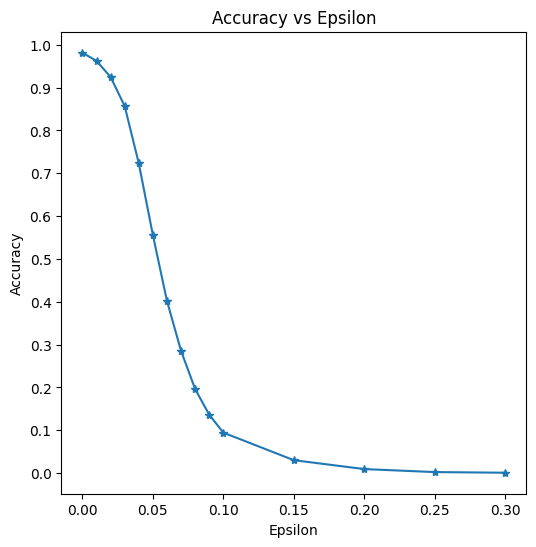

In [10]:
# plot accuracy vs epsilon
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, '*-')
plt.title("Accuracy vs Epsilon")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.savefig('accuracy_vs_epsilon.png')
plt.show()


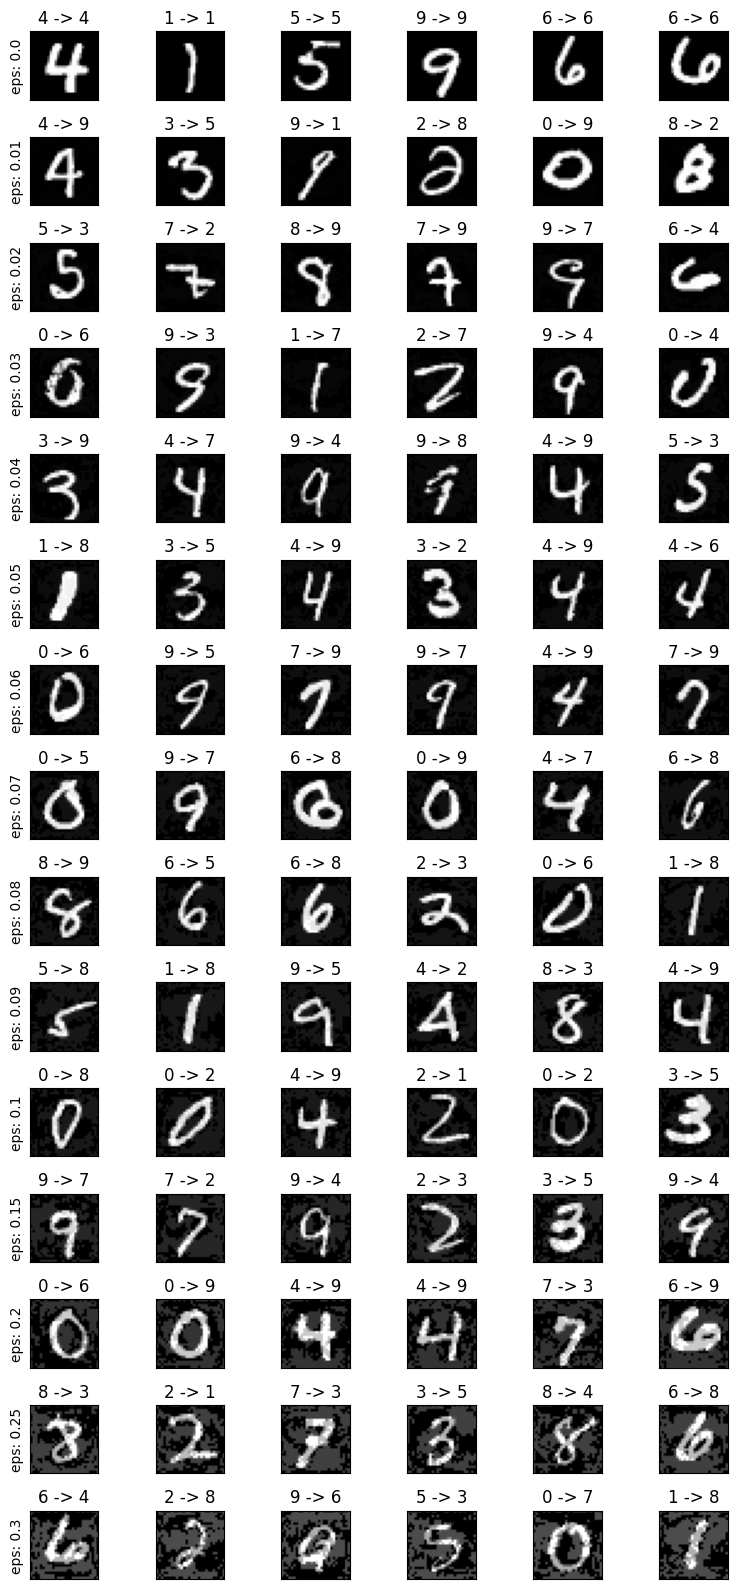

In [11]:
# plot adversarial examples
cnt = 0
plt.figure(figsize=(8, 16))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f'eps: {epsilons[i]}')
        orig, adv, ex = examples[i][j]
        plt.title(f'{orig} -> {adv}')
        plt.imshow(ex, cmap='gray')
plt.tight_layout()
plt.savefig('adv_example_mnist_fgsm.png')
plt.show()
